In [1]:
# ✅ Load & Evaluate Saved TradeTransformer Model

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import ta
import os

In [2]:
# 🧠 Define the model class again (must match the architecture used before)
class TimeSeriesTransformer(torch.nn.Module):
    def __init__(self, input_dim, seq_length, pred_length):
        super().__init__()
        self.d_model = 64
        self.input_fc = torch.nn.Linear(input_dim, self.d_model)
        self.pos_embedding = torch.nn.Parameter(torch.zeros(1, seq_length, self.d_model))
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=self.d_model, nhead=8, dim_feedforward=256, batch_first=True)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.price_head = torch.nn.Linear(self.d_model, pred_length)
        self.class_head = torch.nn.Linear(self.d_model, 1)

    def forward(self, x):
        x = self.input_fc(x) + self.pos_embedding[:, :x.size(1), :]
        x = self.encoder(x)
        last_step = x[:, -1, :]
        return self.price_head(last_step), self.class_head(last_step).squeeze(-1)


In [3]:
# 📂 Load model
model = TimeSeriesTransformer(input_dim=18, seq_length=60, pred_length=1)  # input_dim must match training config
model.load_state_dict(torch.load("../Models/trained_trade_transformer.pth", map_location='cpu'))
model.eval()

TimeSeriesTransformer(
  (input_fc): Linear(in_features=18, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (price_head): Linear(in_features=64, out_features=1, bias=True)
  (class_head): Linear(in_features=64, out_features=1, bias=True)
)

In [4]:
# 🧪 Data Preparation Helpers
def add_technical_indicators(df):
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    bb = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['bb_high'] = bb.bollinger_hband()
    df['bb_low'] = bb.bollinger_lband()
    df['ma_20'] = df['Close'].rolling(20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()
    df['macd'] = ta.trend.macd_diff(df['Close'])
    df['ema_12'] = ta.trend.ema_indicator(df['Close'], window=12)
    df['ema_26'] = ta.trend.ema_indicator(df['Close'], window=26)
    df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
    df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'])
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'])
    df['obv'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
    df['Ticker_ID'] = 0  # test ticker
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

In [5]:
def prepare_data(csv_file):
    df = pd.read_csv(csv_file, delimiter='\t')
    df.columns = df.columns.str.strip()
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df = add_technical_indicators(df)
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'bb_high', 'bb_low', 'ma_20',
                    'ma_20_slope', 'macd', 'ema_12', 'ema_26', 'atr', 'adx', 'cci', 'obv', 'Ticker_ID']
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[feature_cols])
    return scaled, scaler, feature_cols


In [11]:
# 📊 Evaluation & Plot
def evaluate_and_plot(model, data_scaled, scaler, feature_cols, seq_length=60, pred_length=1):
    target_idx = feature_cols.index('Close')
    real_prices = []
    predicted_prices = []
    for i in range(len(data_scaled) - seq_length - pred_length):
        x = data_scaled[i:i+seq_length]
        y = data_scaled[i+seq_length:i+seq_length+pred_length, target_idx]
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        pred, _ = model(x_tensor)
        dummy_pred = np.zeros((pred_length, len(feature_cols)))
        dummy_pred[:, target_idx] = pred.detach().numpy()[0]
        dummy_real = np.zeros((pred_length, len(feature_cols)))
        dummy_real[:, target_idx] = y
        predicted_prices.extend(scaler.inverse_transform(dummy_pred)[:, target_idx])
        real_prices.extend(scaler.inverse_transform(dummy_real)[:, target_idx])
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(real_prices, label="Real")
    plt.plot(predicted_prices, label="Predicted")
    plt.legend()
    plt.title("Model Inference on New Data")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Buy when predicted increase, sell when predicted decrease
    strategy_returns = np.sign(np.diff(predicted_prices)) * np.diff(real_prices)
    cumulative_strategy = np.cumsum(strategy_returns)
    cumulative_real = np.cumsum(np.diff(real_prices))

    plt.figure(figsize=(12,6))
    plt.plot(cumulative_real, label='Actual Returns (Buy-Hold)')
    plt.plot(cumulative_strategy, label='Strategy Returns (Predicted Direction)')
    plt.title('Cumulative Returns Comparison')
    plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(real_prices, predicted_prices, alpha=0.5)
    plt.plot([min(real_prices), max(real_prices)], [min(real_prices), max(real_prices)], 'r--')
    plt.xlabel('Real Close Price')
    plt.ylabel('Predicted Close Price')
    plt.title('Real vs Predicted Price Scatter')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_12333/1811647770.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_12333/1811647770.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


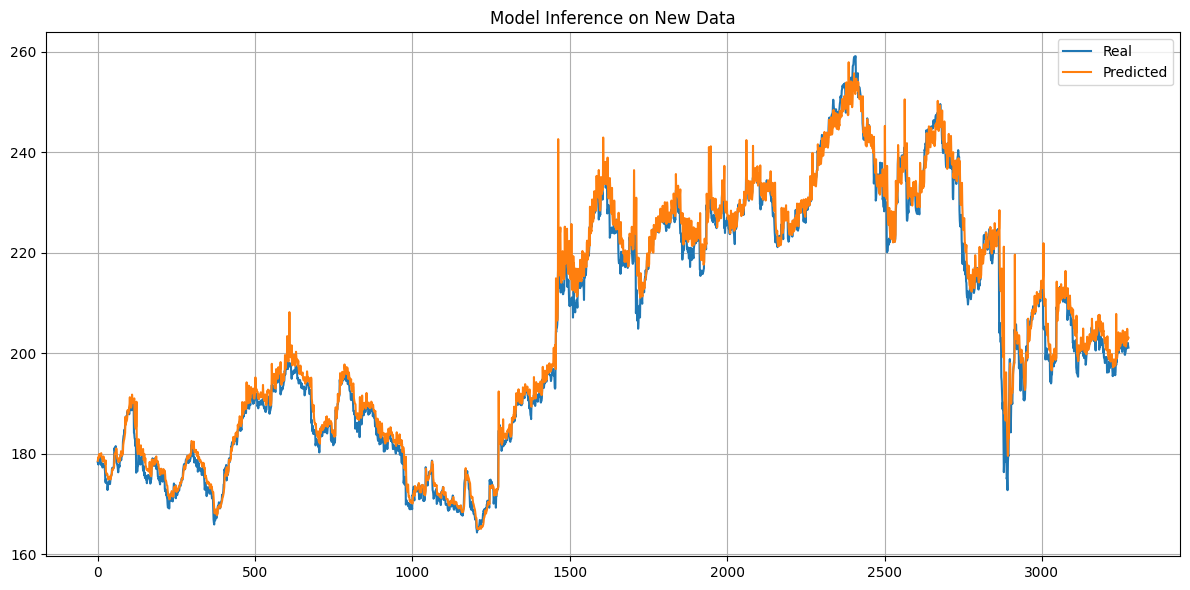

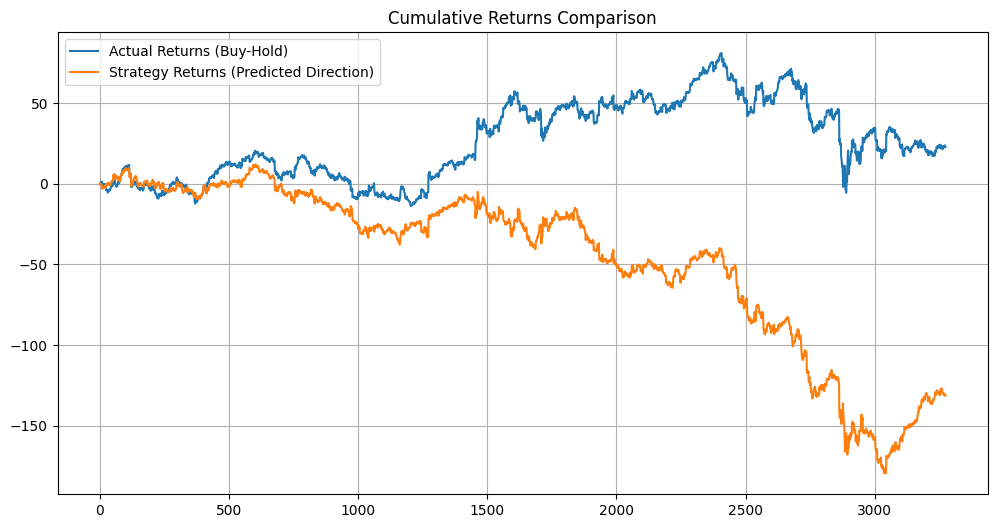

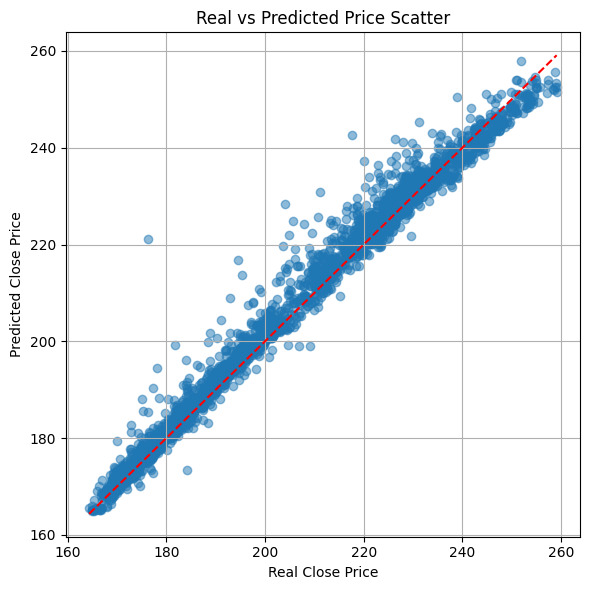

In [12]:
# ✅ Load new test data file
csv_file = "../Output/formatted_data_1h/AAPL_1h_data.csv"  # Replace with your own path
data_scaled, scaler, feature_cols = prepare_data(csv_file)
evaluate_and_plot(model, data_scaled, scaler, feature_cols)
